#**FINE TUNING NOTEBOOK** 
This notebook will do the fine tuning. The process show in the flow chart below.

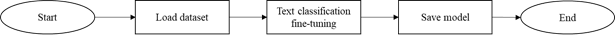

#Import Library

In [ ]:
!pip install transformers datasets -qq

     |████████████████████████████████| 4.7 MB 4.3 MB/s 
     |████████████████████████████████| 365 kB 73.3 MB/s 
     |████████████████████████████████| 6.6 MB 53.6 MB/s 
     |████████████████████████████████| 101 kB 11.5 MB/s 
     |████████████████████████████████| 596 kB 61.7 MB/s 
     |████████████████████████████████| 141 kB 55.5 MB/s 
     |████████████████████████████████| 115 kB 60.5 MB/s 
     |████████████████████████████████| 212 kB 61.2 MB/s 
     |████████████████████████████████| 127 kB 53.4 MB/s 


In [ ]:
#import library
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer,TextClassificationPipeline
from transformers import EarlyStoppingCallback


import pandas as pd
import numpy as np
from datasets import load_dataset
from datasets import load_metric
from datasets import Dataset


import nltk
nltk.download('punkt')

import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Run this if you use Google Colab
'''
from google.colab import drive
drive.mount('/content/drive')
'''

Mounted at /content/drive


#Functions

In [ ]:
#function for calculate the metrics
def compute_metrics(eval_pred):
    metric1 = load_metric("accuracy")
    metric2 = load_metric("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric1.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = metric2.compute(predictions=predictions, references=labels,average="weighted")["f1"]
    return {"accuracy": accuracy,"f1":f1}

#Load Data

In [ ]:
#change the root path and data filename path
root = "/content/drive/MyDrive/Colab Notebooks/Dataset/"
data_filename = ""
train_file_path = root + data_filename + "_train.csv"
val_file_path = root + data_filename + "_val.csv"

In [ ]:
df_train  pd.read_csv(train_file_path)
df_val = pd.read_csv(val_file_path)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
  
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)  

tokenized_datasets_train = train_dataset.map(tokenize_function, batched=True)
tokenized_datasets_val = val_dataset.map(tokenize_function, batched=True)

In [ ]:
#get a number of label in the dataset
num_labels = len(df_train["label"].unique())

#Fine tuning 

In [ ]:
#name the pre-trainied model: roberta-base, sentence-transformers/nli-roberta-base-v2, princeton-nlp/sup-simcse-roberta-base
pretrained_model = "princeton-nlp/sup-simcse-roberta-base"

#download pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=num_labels)


tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

In [ ]:
#create Traning Arguments with hyperparameter
#more information https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments
training_args = TrainingArguments(output_dir="test_trainer", 
                                  evaluation_strategy="epoch",
                                  save_strategy = "epoch",
                                  num_train_epochs=epochs,
                                  learning_rate=1e-05,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  logging_steps = 100,
                                  weight_decay=0.1,
                                  load_best_model_at_end=True,
                                  metric_for_best_model = "eval_f1",
                                  greater_is_better = True
                                  )

In [ ]:
#define trainer for training
#more information https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/trainer#transformers.Trainer
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=tokenized_datasets_train,
  eval_dataset=tokenized_datasets_val,
  compute_metrics=compute_metrics,
  callbacks = [EarlyStoppingCallback(early_stopping_patience = 2)],
)

#start traning
trainer.train()

#Save model
This part for saving fine-tune models

In [ ]:
#create a path to store the fine-tune model
model_path = '/content/drive/MyDrive/Colab Notebooks/Model/SimCSE-RoBERTa-document-agnews'

In [ ]:
#save model
trainer.save_model(model_path)
#save tokenizer
tokenizer.save_pretrained(model_path)

#The end